<img src="../images/GA-logo.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Evidence-Based Political Analysis in the Age of Social Media


**Primary Objectives:**

1. Scrape tweets from two Twitter accounts
2. Use NLP to train a classifier to predict the account a given tweet comes from (i.e. binary classification)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

from textblob import TextBlob

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from scipy.stats import uniform, randint
import ast

from model_evaluation import fill_na_with_blank, lemmatize_column, avg_f1_score, compute_score, get_wrongs

import dill

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

----

## Data Import and Split

In [3]:
# read in the cleaned data files
tweets = pd.read_csv('../datasets/tweets_cleaned.csv')

In [4]:
# split into train and test datasets
X = tweets[['cleanedContent', 'content_length', 'hashtags', 'sentiment_score',
            'num_links_TextLink', 'num_media_Video', 'num_media_Photo', 'num_media_Gif',
            'likeCount', 'quoteCount', 'part_of_convo']]
y = tweets['account']
# convert y into boolean, where pap=1 and wp=0
y = pd.Series([1 if row == 'pap' else 0 for row in y], name=y.name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

----
## Feature Engineering

Taking into account the results from the EDA, we will engineer the features as follows:
| Feature | Input Variables | Pre-Processing |
|--------|--------|--------|
| Messaging | `cleanedContent` | Vectorise with TFIDF |
|  | `content_length` | No further processing |
|  | `hashtags` | Vectorise with TFIDF |
| Tone | `sentiment_score` | No further processing |
| Content Type | `num_links_TextLink`, `num_media_Video`, `num_media_Photo`, `num_media_Gif` | No further processing |
| Level of Engagement | `likeCount`, `quoteCount`, `part_of_convo` | No further processing |


### Messaging: vectorise `cleanedContent`

In [5]:
def fill_na_with_blank(df):
    
    return df.fillna('')

In [6]:
def lemmatize_column(df):
    
    lemmatizer = WordNetLemmatizer()
    lemm_col = []

    for text in df:
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemm_col.append(' '.join(lemmatized_tokens))

    return pd.Series(lemm_col, name=df.name)
    #else:
    #    return ''
    

In [5]:
# create pipeline
tvec_content_pipe = Pipeline(
    steps=[
        ('filler', FunctionTransformer(fill_na_with_blank, feature_names_out='one-to-one')),
        ('lemmatizer', FunctionTransformer(lambda x: lemmatize_column(x), feature_names_out='one-to-one')),
        ('tvec_content', TfidfVectorizer()),
        ('selector', SelectKBest(score_func=chi2, k=700)) # limit overfitting by selecting only ~ top 25% of words/phrases
        #('denser', FunctionTransformer(lambda x: x.todense(), feature_names_out='one-to-one'))
    ]
)

### Messaging: vectorise `hashtags`

In [8]:
# custom function to vectorise and create dense matrix
def convert_list_to_string(col):
    
    #col = col.fillna([])
    
    #return col.apply(lambda x: ' '.join(x))
    #return col.apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
    return col.apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else '')

In [6]:
# create pipeline for vectorising hashtags
# hashtags is a column in the dataframe with a list of strings for each row
tvec_hashtag_pipe = Pipeline(
    steps=[
        ('filler', FunctionTransformer(fill_na_with_blank, feature_names_out='one-to-one')),
        # join the list of words into a single string for each row
        #('joiner', FunctionTransformer(lambda x: ' '.join(x) if isinstance(x, list) else '', feature_names_out='one-to-one')),
        #('joiner', FunctionTransformer(convert_list_to_string, feature_names_out='one-to-one')),
        # vectorise
        ('tvec_hashtag', TfidfVectorizer()),
        # convert to dense matrix
        #('denser', FunctionTransformer(lambda x: x.todense(), feature_names_out='one-to-one'))
    ]
)

### Tone: `sentiment_scores`

We realise that `sentiment_scores` ranges from -1.0 to 1.0 and this will raise an error in Multinomial Naive Bayes classifier which only takes in positive values. As such, we need to transform `sentiment_scores` into variables - one for positive sentiment and one for negative.

In [7]:
# create function to transform sentiments_scores into positive and negative scores
def transform_scores(df):
    
    df_trans = df.apply(lambda x: pd.Series([max(x,0), max(-x,0)]))
    df_trans.columns = [df.name+'_pos', df.name+'_neg']
    
    return df_trans

### Pre-processor for predictor variables

In [8]:
# putting all the preprocessing steps together in one pipeline for Multinomial Naive Bayes classifier which cannot take in negative values
preprocessor_NB = ColumnTransformer(
    transformers=[
        ('sent_transformer', FunctionTransformer(transform_scores, feature_names_out='one-to_one'), 'sentiment_score'),
        ('content_transformer', tvec_content_pipe, 'cleanedContent'),
        ('hashtag_transformer', tvec_hashtag_pipe, 'hashtags')
    ],
    remainder='passthrough', verbose_feature_names_out=True
)

In [9]:
# putting all the preprocessing steps together in one pipeline for other classifiers
preprocessor = ColumnTransformer(
    transformers=[
        ('content_transformer', tvec_content_pipe, 'cleanedContent'),
        ('hashtag_transformer', tvec_hashtag_pipe, 'hashtags')
    ],
    remainder='passthrough', verbose_feature_names_out=True
)

In [10]:
# putting all the preprocessing steps together in one pipeline for other classifiers
# the simplified preprocessor only uses the content, i.e. tweet and hashtags for classification
preprocessor_simplified = ColumnTransformer(
    transformers=[
        ('content_transformer', tvec_content_pipe, 'cleanedContent'),
        ('hashtag_transformer', tvec_hashtag_pipe, 'hashtags')
    ],
    remainder='drop', verbose_feature_names_out=True
)

----

## Model Fitting and Tuning

#### Selection of model metric
For model evaluation, there are many metrics that can be used. For this problem statement, we will use average F1 score to provide a balance between precision and recall. This is because:
1. The dataset is quite balanced between the 2 Twitter accounts
2. Classifying the tweet wrongly either way is equally detrimental

Hence, we will not prioritise precision or recall but aim to get the best F1 score instead.

#### Models to be fitted and evaluated

We will try the following classifier models and choose the model with the best training dataset F1 score.
1. **Model A**: Naive Bayes
2. **Model B**: Random Forest
4. **Model C**: Logistic Regression

For each of the models, we also try a variation that focuses only on the messaging of the tweet (i.e. `cleanedContent` and `hashtags` only). This greatly simplifies the model and tests the hypothesis of whether the other aspects of the tweet make the classifier better.

In [11]:
# making scorer object
scorer = make_scorer(avg_f1_score)

### Baseline Model

The baseline model takes a mode strategy. We note that the average F1 score is **0.337**

Our models should get a better average F1 score than this baseline

In [12]:
y_pred = y_test.value_counts(normalize=True).sort_values(ascending=False).index[0]

In [13]:
print(f'F1 Score for baseline model is {avg_f1_score(y_test, y_pred*np.ones(y_test.shape)):.3f}.')

F1 Score for baseline model is 0.337.


### Model A: Naive Bayes

We test out a Naive Bayes model and check its F1 score. To increase the efficiency of tuning the hyperparameters, we use RandomizedSearchCV to iteratively narrow down on the optimal hyperparameters. We also use 5-fold cross validation to minimise the risk of overfitting.

In summary, the optimal Naive Bayes model details as follows:

| **Metrics** |  |  | **Hyperparameters** |  |
|:--------|--------:|-|:--------|--------:|
| Training Average F1 Score | 0.924 |      | Naive Bayes $\alpha$ | 0.0644 |
| 5-Fold Cross Val Average F1 Score | **0.902** |  | `cleanedContent`: `max_df` | 0.6037 |
|  |  |  | `cleanedContent`: `stop_words` | `'english'` |
|  |  |  | `cleanedContent`: `ngram_range` | 1~3 |
|  |  |  | `hashtag`: `max_df` | 0.2955 |
|  |  |  | `hashtag`: `stop_words` | `'english'` |


#### Initial run to identify regions of importance

In [14]:
# construct pipeline for model A
model_NB = Pipeline(
    steps=[
        ('preproc', preprocessor_NB),
        ('model', MultinomialNB())
    ]
)

In [21]:
# set hyperparameters for tuning
model_NB_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0,1), 
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0,1),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__alpha': uniform(0,1) 
}

In [17]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_NB_randsearch = RandomizedSearchCV(
    model_NB, model_NB_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [18]:
%%time
# fit model and tune hyperparamters
model_NB_randsearch.fit(X_train, y_train)

CPU times: total: 4.03 s
Wall time: 1min 26s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('sent_transformer',
                                                                               FunctionTransformer(feature_names_out='one-to_one',
                                                                                                   func=<function transform_scores at 0x0000028F0DB25160>),
                                                                               'sentiment_score'),
                                                                              ('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='on...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F14A09820>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.922
5-Fold CV Average F1 Score: 	0.900
{'model__alpha': 0.09602971015387929,
 'preproc__content_transformer__tvec_content__max_df': 0.9434910369995324,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.8260501471973274,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


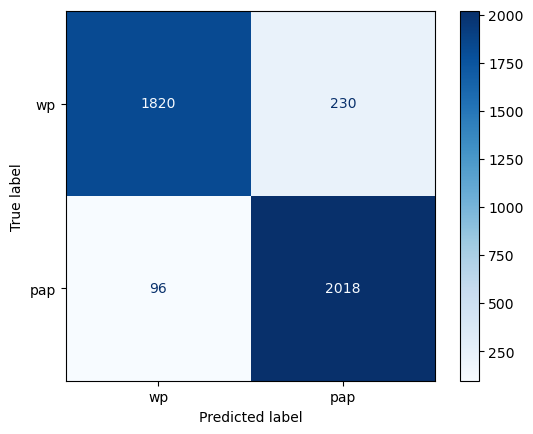

In [19]:
# look at matrics
model_NB_scores = compute_score(model_NB_randsearch, X_train, y_train)

<AxesSubplot:xlabel='hash_bins', ylabel='content_bins'>

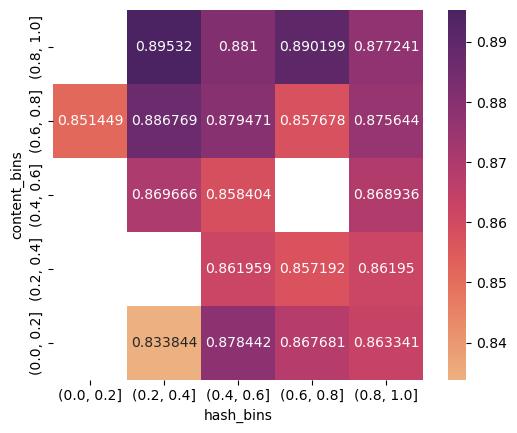

In [20]:
# plot heatmap of max_dfs to identify best region to tune
NB_params = pd.DataFrame(model_NB_randsearch.cv_results_)
NB_params['param_preproc__content_transformer__tvec_content__max_df'] = NB_params['param_preproc__content_transformer__tvec_content__max_df'].astype('float')
NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'] = NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'].astype('float')

NB_params['content_bins'] = pd.cut(NB_params['param_preproc__content_transformer__tvec_content__max_df'], bins=np.linspace(0,1,6))
NB_params['hash_bins'] = pd.cut(NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'], bins=np.linspace(0,1,6))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='content_bins', columns='hash_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

From the first fitting of the Naive Bayes model, we note that the performance is best for the following ranges of `max_df` for `cleanedContent` and `hashtags`:
1. `cleanedContent`: 0.8 ~ 1.0
2. `hashtags`: 0.2 ~ 0.4

We zoom in to these value ranges to finetune the model

#### Finetuning hyparameters

In [22]:
# set hyperparameters for tuning
model_NB_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0.6,0.4),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0.2,0.2),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__alpha': uniform(0,1) 
}

In [23]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_NB_randsearch = RandomizedSearchCV(
    model_NB, model_NB_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [24]:
%%time
# fit model and tune hyperparamters
model_NB_randsearch.fit(X_train, y_train)

CPU times: total: 2.66 s
Wall time: 1min 30s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('sent_transformer',
                                                                               FunctionTransformer(feature_names_out='one-to_one',
                                                                                                   func=<function transform_scores at 0x0000028F0DB25160>),
                                                                               'sentiment_score'),
                                                                              ('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='on...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F15D84340>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.924
5-Fold CV Average F1 Score: 	0.902
{'model__alpha': 0.06441640513466074,
 'preproc__content_transformer__tvec_content__max_df': 0.6037176494218719,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.29545252606552663,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9237039568701484, 0.902169163867583)

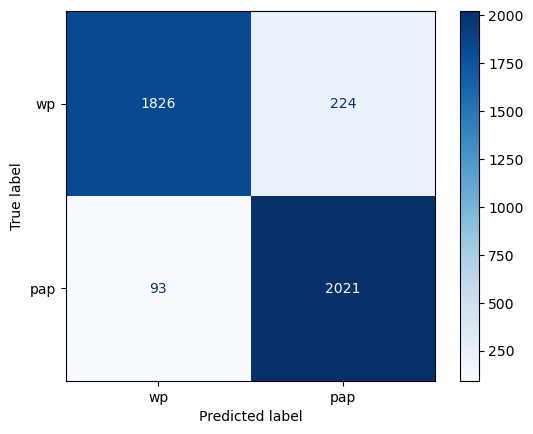

In [25]:
# look at matrics
compute_score(model_NB_randsearch, X_train, y_train)

Observation:

- Number of wrong predictions tend to be higher for WP's tweets than that of PAP's (almost triple), even though the datasets are of around equal number
- This suggests that the model may be better at predicting PAP's tweets than WP's
- However, the overall cross-val average F1 score is still quite good at 0.902

### Model A Simplified: Naive Bayes on only the Messaging

We take the same approach as described above.

The optimal simplified Naive Bayes model details are as follows:


| **Metrics** |  |  | **Hyperparameters** |  |
|:--------|--------:|-|:--------|--------:|
| Training Average F1 Score | 0.950 |      | Naive Bayes $\alpha$ | 0.9233 |
| 5-Fold Cross Val Average F1 Score | **0.925** |  | `cleanedContent`: `max_df` | 0.6607 |
|  |  |  | `cleanedContent`: `stop_words` | `'english'` |
|  |  |  | `cleanedContent`: `ngram_range` | 1~3 |
|  |  |  | `hashtag`: `max_df` | 0.7692 |
|  |  |  | `hashtag`: `stop_words` | `'english'` |



#### Initial run to identify regions of importance

In [26]:
# construct pipeline for model A simplified
model_NB_simplified = Pipeline(
    steps=[
        ('preproc', preprocessor_simplified),
        ('model', MultinomialNB())
    ]
)

In [27]:
# set hyperparameters for tuning
model_NB_simplified_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0,1),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0,1),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__alpha': uniform(0,1)
}

In [28]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_NB_simplified_randsearch = RandomizedSearchCV(
    model_NB_simplified, model_NB_simplified_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [29]:
%%time
# fit model and tune hyperparamters
model_NB_simplified_randsearch.fit(X_train, y_train)

CPU times: total: 1.61 s
Wall time: 57.7 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function <lambda> at 0x0000028F14...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F1C0AAB80>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.950
5-Fold CV Average F1 Score: 	0.925
{'model__alpha': 0.9232667066664217,
 'preproc__content_transformer__tvec_content__max_df': 0.303693313961628,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.8461034903175555,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9502061629656503, 0.9251746651592596)

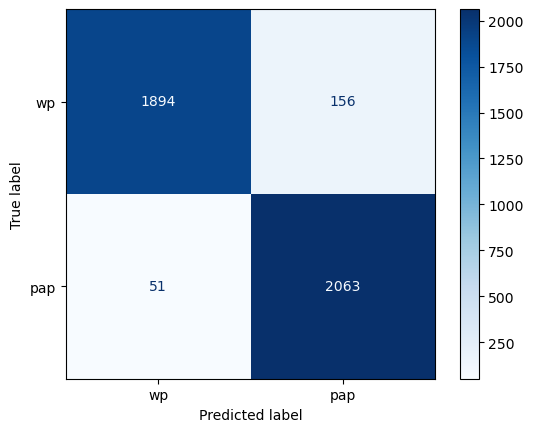

In [30]:
# look at matrics
compute_score(model_NB_simplified_randsearch, X_train, y_train)

<AxesSubplot:xlabel='hash_bins', ylabel='content_bins'>

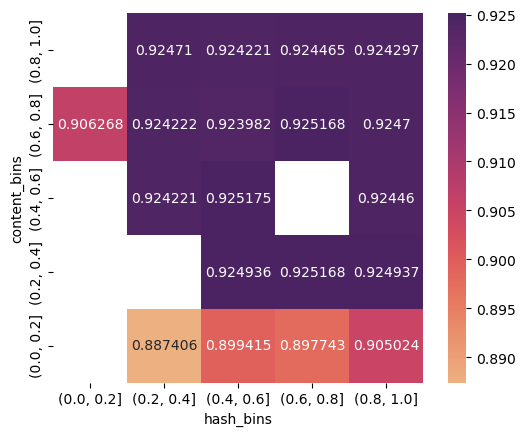

In [31]:
# analyse heatmap to tune max_df
NB_params = pd.DataFrame(model_NB_simplified_randsearch.cv_results_)
NB_params['param_preproc__content_transformer__tvec_content__max_df'] = NB_params['param_preproc__content_transformer__tvec_content__max_df'].astype('float')
NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'] = NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'].astype('float')

NB_params['content_bins'] = pd.cut(NB_params['param_preproc__content_transformer__tvec_content__max_df'], bins=np.linspace(0,1,6))
NB_params['hash_bins'] = pd.cut(NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'], bins=np.linspace(0,1,6))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='content_bins', columns='hash_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

From the first fitting of the Naive Bayes model, we note that the performance is best for the following ranges of `max_df` for `cleanedContent` and `hashtags`:
1. `cleanedContent`: 0.6 ~ 0.8
2. `hashtags`: 0.6 ~ 0.8

We zoom in to these value ranges to finetune the model

#### Finetuning hyparameters

In [26]:
# construct pipeline for model A simplified
model_NB_simplified = Pipeline(
    steps=[
        ('preproc', preprocessor_simplified),
        ('model', MultinomialNB())
    ]
)

In [32]:
# set hyperparameters for tuning
model_NB_simplified_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0.6,0.2), 
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0.6,0.2), 
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__alpha': uniform(0,1) 
}

In [33]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_NB_simplified_randsearch = RandomizedSearchCV(
    model_NB_simplified, model_NB_simplified_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [34]:
%%time
# fit model and tune hyperparamters
model_NB_simplified_randsearch.fit(X_train, y_train)

CPU times: total: 1.48 s
Wall time: 1min


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function <lambda> at 0x0000028F14...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F1B164DF0>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.950
5-Fold CV Average F1 Score: 	0.925
{'model__alpha': 0.9232667066664217,
 'preproc__content_transformer__tvec_content__max_df': 0.6607386627923256,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.7692206980635111,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9502061629656503, 0.9251746651592596)

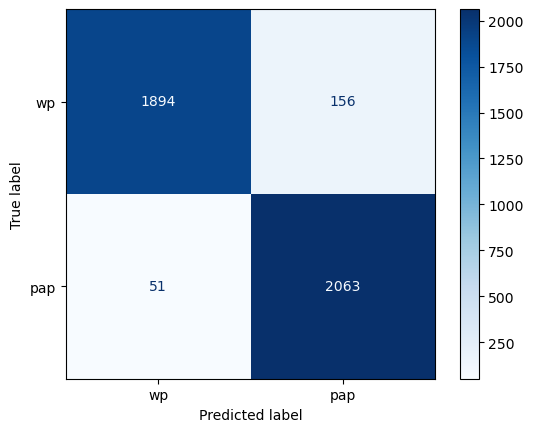

In [35]:
# look at matrics
compute_score(model_NB_simplified_randsearch, X_train, y_train)

Observation:

- Simplified model performs significantly better on the NB model
- Very small number of wrong predictions, but there are signs of overfitting which is common for NLP models
- Nonetheless, the CV score of 0.925 is still relatively good and higher than the full model


### Model B: Random Forest

We take the same approach as described above, with RandomForestClassifier.

The optimal Random Forest model details are as follows:


| **Metrics** |  |  | **Hyperparameters** |  |
|:--------|--------:|-|:--------|--------:|
| Training Average F1 Score | 0.937 |      | Random Forest `bootstrap` | `True` |
| 5-Fold Cross Val Average F1 Score | **0.918** |  | Random Forest `max_depth` | 40 |
|  |  |  | Random Forest `min_samples_leaf` | 5 |
|  |  |  | Random Forest `min_samples_split` | 34 |
|  |  |  | Random Forest `n_estimators` | 850 |
|  |  |  | `cleanedContent`: `max_df` | 0.8009 |
|  |  |  | `cleanedContent`: `stop_words` | `'english'` |
|  |  |  | `cleanedContent`: `ngram_range` | 1 |
|  |  |  | `hashtag`: `max_df` | 0.3676 |
|  |  |  | `hashtag`: `stop_words` | `'english'` |



#### Initial run to identify regions of importance

In [37]:
# construct pipeline for model B
model_RF = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('model', RandomForestClassifier())
    ]
)

In [38]:
# set hyperparameters for tuning
model_RF_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0,1),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,1), (1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0,1),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__n_estimators': [850],
    'model__min_samples_split': randint(20, 60),
    'model__min_samples_leaf': randint(5, 20),
    'model__max_depth': [40],
    'model__bootstrap': [True]
}

In [39]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_RF_randsearch = RandomizedSearchCV(
    model_RF, model_RF_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [40]:
%%time
# fit model and tune hyperparamters
model_RF_randsearch.fit(X_train, y_train)

CPU times: total: 5.44 s
Wall time: 2min 54s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<functi...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     1),
                                                                                                    (1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F1C0B3940>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.935
5-Fold CV Average F1 Score: 	0.921
{'model__bootstrap': True,
 'model__max_depth': 40,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 40,
 'model__n_estimators': 850,
 'preproc__content_transformer__tvec_content__max_df': 0.8188741052238304,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 1),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.32294417065436043,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9354133894497054, 0.9206327617713047)

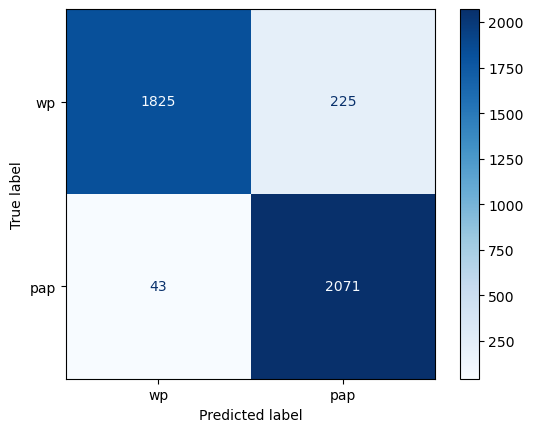

In [41]:
# look at matrics
compute_score(model_RF_randsearch, X_train, y_train)

<AxesSubplot:xlabel='hash_bins', ylabel='content_bins'>

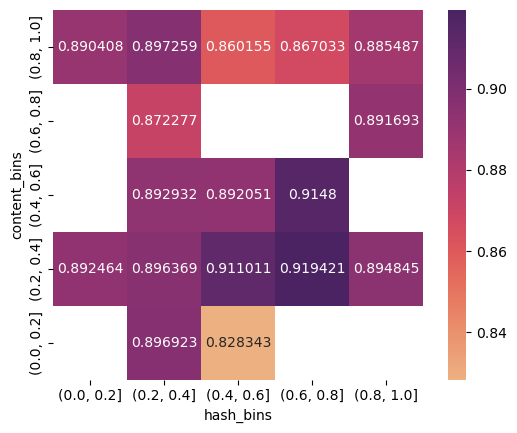

In [44]:
# examine heatmap to finetune max_df
NB_params = pd.DataFrame(model_RF_randsearch.cv_results_)
NB_params['param_preproc__content_transformer__tvec_content__max_df'] = NB_params['param_preproc__content_transformer__tvec_content__max_df'].astype('float')
NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'] = NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'].astype('float')

NB_params['content_bins'] = pd.cut(NB_params['param_preproc__content_transformer__tvec_content__max_df'], bins=np.linspace(0,1,6))
NB_params['hash_bins'] = pd.cut(NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'], bins=np.linspace(0,1,6))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='content_bins', columns='hash_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

<AxesSubplot:xlabel='split_bins', ylabel='leaf_bins'>

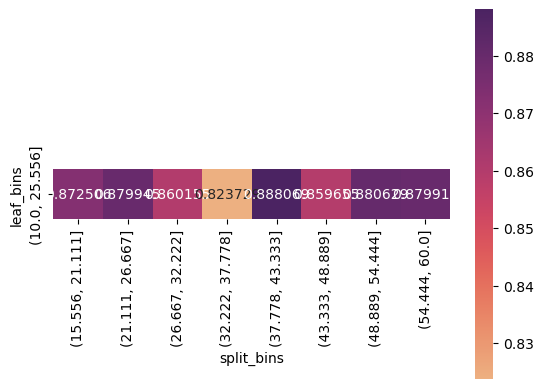

In [45]:
# examine heatmap to finetune min_leaf and min_split
NB_params = pd.DataFrame(model_RF_randsearch.cv_results_)
NB_params['param_model__min_samples_leaf'] = NB_params['param_model__min_samples_leaf'].astype('float')
NB_params['param_model__min_samples_split'] = NB_params['param_model__min_samples_split'].astype('float')

NB_params['leaf_bins'] = pd.cut(NB_params['param_model__min_samples_leaf'], bins=np.linspace(10,150,num=10))
NB_params['split_bins'] = pd.cut(NB_params['param_model__min_samples_split'], bins=np.linspace(10,60,num=10))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='leaf_bins', columns='split_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

From the first fitting of the Random Forest model, we note that the performance is best for the following ranges of `max_df` for `cleanedContent` and `hashtags`:
1. `cleanedContent`: 0.6 ~ 1.0
2. `hashtags`: 0.2 ~ 0.6

For `min_leaf` and `min_samples`:
1. `min_leaf`: 5 ~ 20
2. `min_split`: 30 ~ 50

We zoom in to these value ranges to finetune the model

#### Finetuning hyparameters

In [61]:
# set hyperparameters for tuning
model_RF_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0.6,0.4),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,1), (1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0.2,0.4),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__n_estimators': [850],
    'model__min_samples_split': randint(30, 50),
    'model__min_samples_leaf': randint(5, 20),
    'model__max_depth': [40],
    'model__bootstrap': [True]
}

In [62]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_RF_randsearch = RandomizedSearchCV(
    model_RF, model_RF_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [63]:
%%time
# fit model and tune hyperparamters
model_RF_randsearch.fit(X_train, y_train)

CPU times: total: 5.78 s
Wall time: 2min 52s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<functi...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     1),
                                                                                                    (1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F2165BF10>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.937
5-Fold CV Average F1 Score: 	0.918
{'model__bootstrap': True,
 'model__max_depth': 40,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 34,
 'model__n_estimators': 850,
 'preproc__content_transformer__tvec_content__max_df': 0.8009332841267858,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 1),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.3676191493929444,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9371196084442941, 0.9184610302987402)

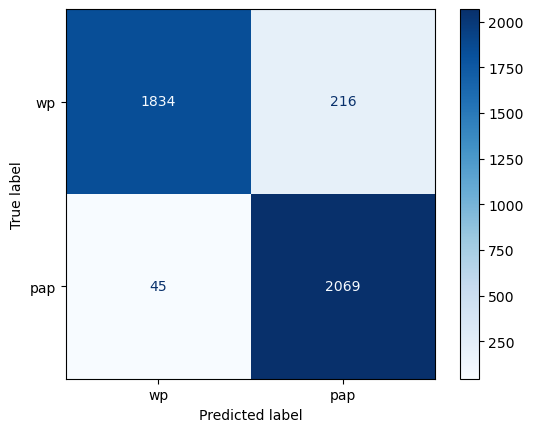

In [64]:
# look at matrics
compute_score(model_RF_randsearch, X_train, y_train)

Observation:

- RF model has marginally better than NB model, but still much lower average F1 score than the simplified NB model
- In addition, even though average F1 score is used to attempt to balance out the precision and recall of both PAP and WP tweets, the RF model seems to classify WP's tweets with significantly greater precision and recall then PAP's


### Model B Simplified: Random Forest on only the Messaging

We apply only the Messaging variables to RandomForestClassifier.

The optimal simplified Random Forest model details are as follows:


| **Metrics** |  |  | **Hyperparameters** |  |
|:--------|--------:|-|:--------|--------:|
| Training Average F1 Score | 0.967 |      | Random Forest `bootstrap` | `True` |
| 5-Fold Cross Val Average F1 Score | **0.918** |  | Random Forest `max_depth` | None |
|  |  |  | Random Forest `min_samples_leaf` | 1 |
|  |  |  | Random Forest `min_samples_split` | 35 |
|  |  |  | Random Forest `n_estimators` | 850 |
|  |  |  | `cleanedContent`: `max_df` | 0.8901 |
|  |  |  | `cleanedContent`: `stop_words` | `'english'` |
|  |  |  | `cleanedContent`: `ngram_range` | 1~3 |
|  |  |  | `hashtag`: `max_df` | 0.9726 |
|  |  |  | `hashtag`: `stop_words` | `'english'` |



#### Initial run to identify regions of importance

In [54]:
# construct pipeline for model A simplified
model_RF_simplified = Pipeline(
    steps=[
        ('preproc', preprocessor_simplified),
        ('model', RandomForestClassifier())
    ]
)

In [70]:
# set hyperparameters for tuning
model_RF_simplified_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0,1),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0,1),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__n_estimators': randint(700, 1000),
    'model__min_samples_split': randint(20, 80),
    'model__min_samples_leaf': randint(1, 30),
    'model__max_depth': [50, 60, 70, None],
    'model__bootstrap': [True]
}

In [71]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_RF_simplified_randsearch = RandomizedSearchCV(
    model_RF_simplified, model_RF_simplified_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [72]:
%%time
# fit model and tune hyperparamters
model_RF_simplified_randsearch.fit(X_train, y_train)

CPU times: total: 5.19 s
Wall time: 2min 44s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function <lambda> at 0x0000028F14...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F2325A310>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.919
5-Fold CV Average F1 Score: 	0.903
{'model__bootstrap': True,
 'model__max_depth': 60,
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 23,
 'model__n_estimators': 832,
 'preproc__content_transformer__tvec_content__max_df': 0.6147410203226076,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.21294550210647545,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9194164139080278, 0.902606600800533)

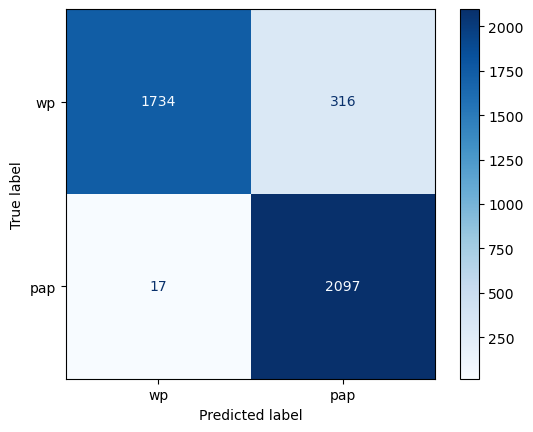

In [73]:
# look at matrics
compute_score(model_RF_simplified_randsearch, X_train, y_train)

<AxesSubplot:xlabel='hash_bins', ylabel='content_bins'>

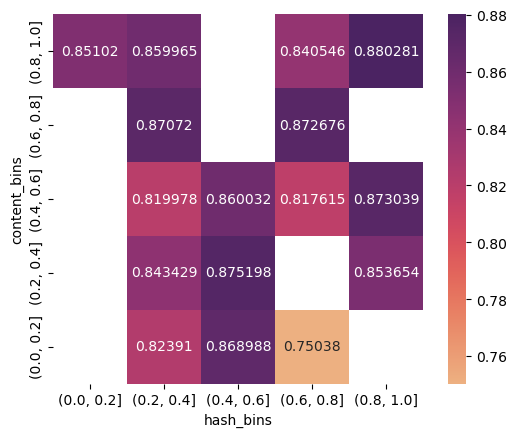

In [74]:
NB_params = pd.DataFrame(model_RF_simplified_randsearch.cv_results_)
NB_params['param_preproc__content_transformer__tvec_content__max_df'] = NB_params['param_preproc__content_transformer__tvec_content__max_df'].astype('float')
NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'] = NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'].astype('float')

NB_params['content_bins'] = pd.cut(NB_params['param_preproc__content_transformer__tvec_content__max_df'], bins=np.linspace(0,1,6))
NB_params['hash_bins'] = pd.cut(NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'], bins=np.linspace(0,1,6))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='content_bins', columns='hash_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

<AxesSubplot:xlabel='split_bins', ylabel='leaf_bins'>

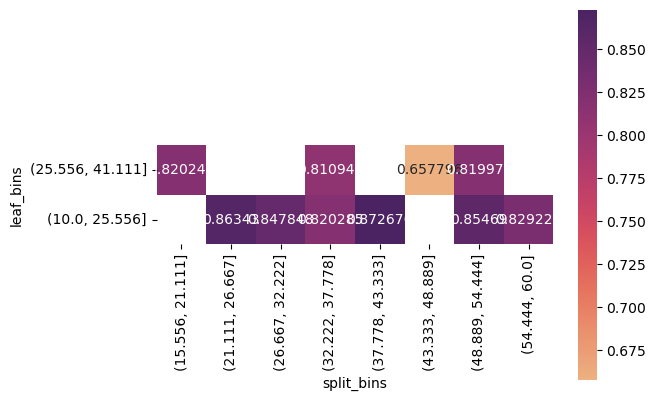

In [75]:
NB_params = pd.DataFrame(model_RF_simplified_randsearch.cv_results_)
NB_params['param_model__min_samples_leaf'] = NB_params['param_model__min_samples_leaf'].astype('float')
NB_params['param_model__min_samples_split'] = NB_params['param_model__min_samples_split'].astype('float')

NB_params['leaf_bins'] = pd.cut(NB_params['param_model__min_samples_leaf'], bins=np.linspace(10,150,num=10))
NB_params['split_bins'] = pd.cut(NB_params['param_model__min_samples_split'], bins=np.linspace(10,60,num=10))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='leaf_bins', columns='split_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

From the first fitting of the Random Forest model, we note that the performance is best for the following ranges of `max_df` for `cleanedContent` and `hashtags`:
1. `cleanedContent`: 0.8 ~ 1.0
2. `hashtags`: 0.8 ~ 1.0

For `min_leaf` and `min_samples`:
1. `min_leaf`: 1 ~ 30
2. `min_split`: 20 ~ 50

We zoom in to these value ranges to finetune the model

#### Finetuning hyparameters

In [86]:
# set hyperparameters for tuning
model_RF_simplified_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0.8,0.2),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0.8,0.2),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english'],
    'model__n_estimators': [850],
    'model__min_samples_split': randint(20, 50),
    'model__min_samples_leaf': randint(1, 30),
    'model__max_depth': [60, 70, None],
    'model__bootstrap': [True]
}

In [87]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_RF_simplified_randsearch = RandomizedSearchCV(
    model_RF_simplified, model_RF_simplified_params, n_iter=30, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [88]:
%%time
# fit model and tune hyperparamters
model_RF_simplified_randsearch.fit(X_train, y_train)

CPU times: total: 9.78 s
Wall time: 3min


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function <lambda> at 0x0000028F14...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F26FCCA00>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': ['english']},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.967
5-Fold CV Average F1 Score: 	0.918
{'model__bootstrap': True,
 'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 35,
 'model__n_estimators': 850,
 'preproc__content_transformer__tvec_content__max_df': 0.8900817661438344,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.9725631781135544,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': 'english'}


(0.9665758390963173, 0.9176548725482754)

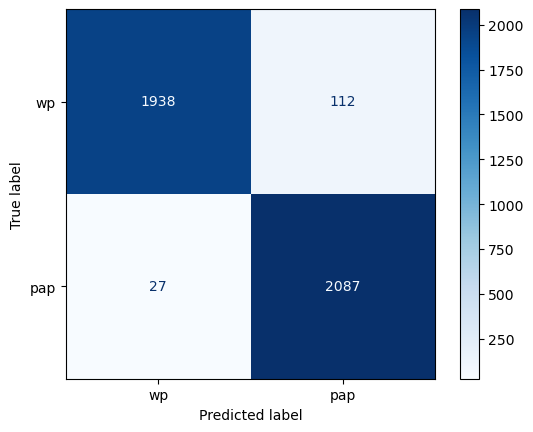

In [89]:
# look at matrics
compute_score(model_RF_simplified_randsearch, X_train, y_train)

Observation:

- The simplified model has same performance as the full model
- Similar to the full model, there is significant imblanace in the predictions where the simplified RF model seems to classify WP's tweets with significantly greater precision and recall then PAP's


### Model C: Logistic Regression

We take the same approach as described above, with Logistic Regression. We have started out with ElasticNet but found that the `l1_ratio` is very close to zero (i.e. ~0.09), as such, we switch to a L2 penalty to reduce implementation time while not compromising performance too much

The optimal Logistic Regression model details are as follows:


| **Metrics** |  |  | **Hyperparameters** |  |
|:--------|--------:|-|:--------|--------:|
| Training Average F1 Score | 0.974 |      | LogReg C | 15.50 |
| 5-Fold Cross Val Average F1 Score | **0.939** |  | `cleanedContent`: `max_df` | 0.8438 |
|  |  |  | `cleanedContent`: `stop_words` | `'english'` |
|  |  |  | `cleanedContent`: `ngram_range` | 1~3 |
|  |  |  | `hashtag`: `max_df` | 0.9369 |
|  |  |  | `hashtag`: `stop_words` | None |



#### Initial run to identify regions of importance

In [65]:
# construct pipeline for model C
model_LR = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('model', LogisticRegression(penalty='l2', solver='liblinear', max_iter=500))
    ]
)

In [66]:
# set hyperparameters for tuning
model_LR_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0,1),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0,1),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None],
    'model__C': uniform(1,500)
}

In [67]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_LR_randsearch = RandomizedSearchCV(
    model_LR, model_LR_params, n_iter=50, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [68]:
%%time
# fit model and tune hyperparamters
model_LR_randsearch.fit(X_train, y_train)

CPU times: total: 2.38 s
Wall time: 1min 39s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<functi...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F21FBF490>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None]},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.974
5-Fold CV Average F1 Score: 	0.939
{'model__C': 15.496888395093443,
 'preproc__content_transformer__tvec_content__max_df': 0.21907665445561775,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.9211754587028063,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': None}


(0.9738101828554433, 0.9389592844500868)

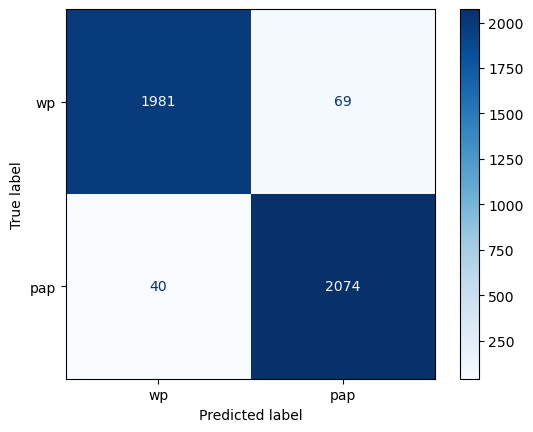

In [69]:
# look at matrics
compute_score(model_LR_randsearch, X_train, y_train)

<AxesSubplot:xlabel='hash_bins', ylabel='content_bins'>

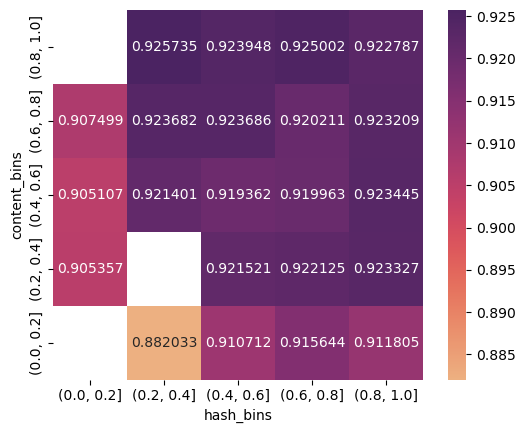

In [89]:
NB_params = pd.DataFrame(model_LR_randsearch.cv_results_)
NB_params['param_preproc__content_transformer__tvec_content__max_df'] = NB_params['param_preproc__content_transformer__tvec_content__max_df'].astype('float')
NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'] = NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'].astype('float')

NB_params['content_bins'] = pd.cut(NB_params['param_preproc__content_transformer__tvec_content__max_df'], bins=np.linspace(0,1,6))
NB_params['hash_bins'] = pd.cut(NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'], bins=np.linspace(0,1,6))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='content_bins', columns='hash_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

<AxesSubplot:xlabel='C_bins'>

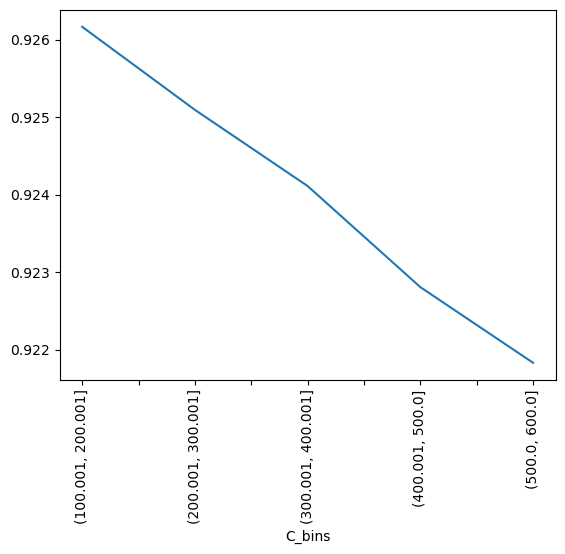

In [100]:
NB_params = pd.DataFrame(model_LR_randsearch.cv_results_)
NB_params['param_model__C'] = NB_params['param_model__C'].astype('float')

NB_params['C_bins'] = pd.cut(NB_params['param_model__C'], bins=np.linspace(1e-3, 1e3, 11))

NB_params.groupby('C_bins').mean()['mean_test_score'].plot(rot=90)

From the first fitting of the Random Forest model, we note that the performance is best for the following ranges of `max_df` for `cleanedContent` and `hashtags`:
1. `cleanedContent`: 0.8 ~ 1.0
2. `hashtags`: 0.2 ~ 1.0

For `C`: the smaller the better

We zoom in to these value ranges to finetune the model

#### Finetuning hyparameters

In [90]:
# set hyperparameters for tuning
model_LR_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0.8,0.2),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0.2,0.8),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None],
    'model__C': uniform(1,500)
}

In [91]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_LR_randsearch = RandomizedSearchCV(
    model_LR, model_LR_params, n_iter=50, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [92]:
%%time
# fit model and tune hyperparamters
model_LR_randsearch.fit(X_train, y_train)

CPU times: total: 2.25 s
Wall time: 1min 38s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<functi...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F27769610>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None]},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.974
5-Fold CV Average F1 Score: 	0.939
{'model__C': 15.496888395093443,
 'preproc__content_transformer__tvec_content__max_df': 0.8438153308911236,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.9369403669622451,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': None}


(0.9738101828554433, 0.9389592844500868)

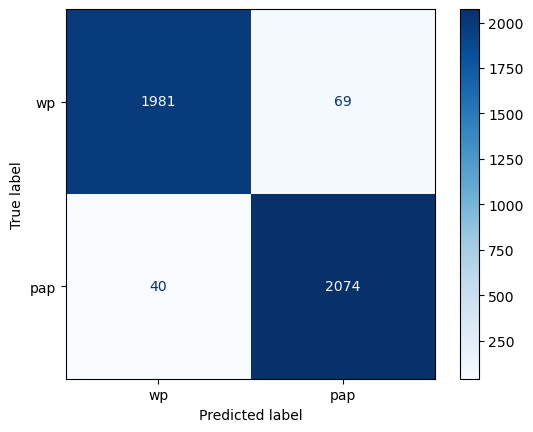

In [93]:
# look at matrics
compute_score(model_LR_randsearch, X_train, y_train)

Observation:

- Best performing model
- Much better balance in the wrong predictions

### Model C Simplified: Logistic Regression on only the Messaging

We apply only Messaging variables to LogReg model.

The optimal Logistic Regression model details are as follows:


| **Metrics** |  |  | **Hyperparameters** |  |
|:--------|--------:|-|:--------|--------:|
| Training Average F1 Score | 0.968 |      | LogReg C | 100.16 |
| 5-Fold Cross Val Average F1 Score | **0.925** |  | `cleanedContent`: `max_df` | 0.8354 |
|  |  |  | `cleanedContent`: `stop_words` | `'english'` |
|  |  |  | `cleanedContent`: `ngram_range` | 1~3 |
|  |  |  | `hashtag`: `max_df` | 0.4925 |
|  |  |  | `hashtag`: `stop_words` | None |



#### Initial run to identify regions of importance

In [94]:
# construct pipeline for model C
model_LR_simplified = Pipeline(
    steps=[
        ('preproc', preprocessor_simplified),
        ('model', LogisticRegression(penalty='l2', solver='liblinear', max_iter=500))
    ]
)

In [95]:
# set hyperparameters for tuning
model_LR_simplified_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0,1),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0,1),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None],
    'model__C': uniform(100, 500)
}

In [96]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_LR_simplified_randsearch = RandomizedSearchCV(
    model_LR_simplified, model_LR_simplified_params, n_iter=50, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [97]:
%%time
# fit model and tune hyperparamters
model_LR_simplified_randsearch.fit(X_train, y_train)

CPU times: total: 2.34 s
Wall time: 1min 40s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function <lambda> at 0x0000028F14...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F26E1D160>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None]},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.968
5-Fold CV Average F1 Score: 	0.925
{'model__C': 100.15813437659523,
 'preproc__content_transformer__tvec_content__max_df': 0.1770067483703981,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.48749549337159603,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': None}


(0.9684867202725878, 0.924940260617271)

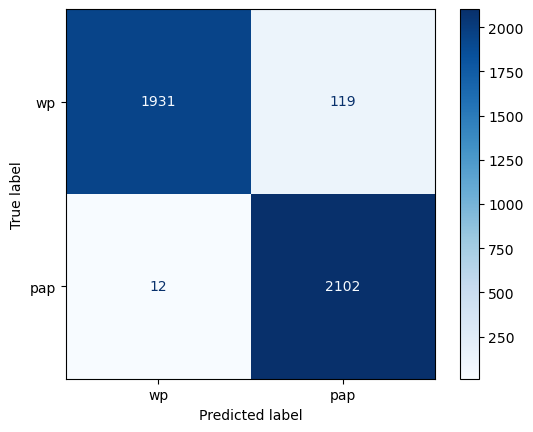

In [98]:
# look at matrics
compute_score(model_LR_simplified_randsearch, X_train, y_train)

<AxesSubplot:xlabel='hash_bins', ylabel='content_bins'>

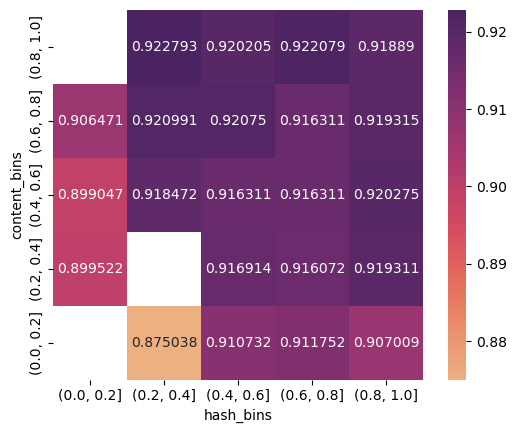

In [99]:
NB_params = pd.DataFrame(model_LR_simplified_randsearch.cv_results_)
NB_params['param_preproc__content_transformer__tvec_content__max_df'] = NB_params['param_preproc__content_transformer__tvec_content__max_df'].astype('float')
NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'] = NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'].astype('float')

NB_params['content_bins'] = pd.cut(NB_params['param_preproc__content_transformer__tvec_content__max_df'], bins=np.linspace(0,1,6))
NB_params['hash_bins'] = pd.cut(NB_params['param_preproc__hashtag_transformer__tvec_hashtag__max_df'], bins=np.linspace(0,1,6))

cv_results = pd.pivot_table(NB_params, values='mean_test_score', index='content_bins', columns='hash_bins')
cv_results = cv_results.reindex(index=cv_results.index[::-1])

sns.heatmap(cv_results, square=True,
            annot=True, fmt='g', cmap='flare')

<AxesSubplot:xlabel='C_bins'>

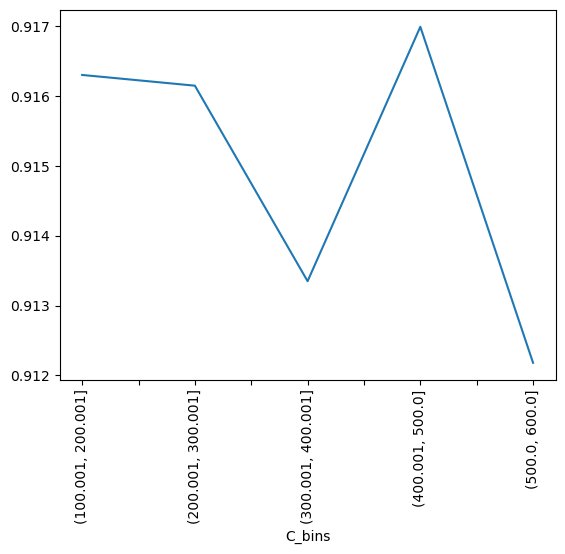

In [100]:
NB_params = pd.DataFrame(model_LR_simplified_randsearch.cv_results_)
NB_params['param_model__C'] = NB_params['param_model__C'].astype('float')

NB_params['C_bins'] = pd.cut(NB_params['param_model__C'], bins=np.linspace(1e-3, 1e3, 11))

NB_params.groupby('C_bins').mean()['mean_test_score'].plot(rot=90)

From the first fitting of the Random Forest model, we note that the performance is best for the following ranges of `max_df` for `cleanedContent` and `hashtags`:
1. `cleanedContent`: 0.8 ~ 1.0
2. `hashtags`: 0.2 ~ 0.8

For `C`: current range looks ok

We zoom in to these value ranges to finetune the model

#### Finetuning hyparameters

In [101]:
# set hyperparameters for tuning
model_LR_simplified_params = {
    'preproc__content_transformer__tvec_content__max_df': uniform(0.8,0.2),
    'preproc__content_transformer__tvec_content__min_df': [5],
    'preproc__content_transformer__tvec_content__stop_words': ['english'],
    'preproc__content_transformer__tvec_content__ngram_range': [(1,3)],
    'preproc__hashtag_transformer__tvec_hashtag__max_df': uniform(0.2,0.6),
    'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None],
    'model__C': uniform(100, 500)
}

In [102]:
# construct RandomizedSearchCV object to tune hyperparameters with F1 score as objective
model_LR_simplified_randsearch = RandomizedSearchCV(
    model_LR_simplified, model_LR_simplified_params, n_iter=50, cv=5, scoring=scorer,
    random_state=200, n_jobs=-1
)

In [103]:
%%time
# fit model and tune hyperparamters
model_LR_simplified_randsearch.fit(X_train, y_train)

CPU times: total: 1.86 s
Wall time: 1min 40s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('content_transformer',
                                                                               Pipeline(steps=[('filler',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function fill_na_with_blank at 0x0000028F14972B80>)),
                                                                                               ('lemmatizer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function <lambda> at 0x0000028F14...
                                        'preproc__content_transformer__tvec_content__ngram_range': [(1,
                                                                                                     3)],
                                        'preproc__content_transformer__tvec_content__stop_words': ['english'],
                                        'preproc__hashtag_transformer__tvec_hashtag__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028F284F9E20>,
                                        'preproc__hashtag_transformer__tvec_hashtag__stop_words': [None]},
                   random_state=200, scoring=make_scorer(avg_f1_score))

Train Average F1 Score: 	0.968
5-Fold CV Average F1 Score: 	0.925
{'model__C': 100.15813437659523,
 'preproc__content_transformer__tvec_content__max_df': 0.8354013496740796,
 'preproc__content_transformer__tvec_content__min_df': 5,
 'preproc__content_transformer__tvec_content__ngram_range': (1, 3),
 'preproc__content_transformer__tvec_content__stop_words': 'english',
 'preproc__hashtag_transformer__tvec_hashtag__max_df': 0.4924972960229576,
 'preproc__hashtag_transformer__tvec_hashtag__stop_words': None}


(0.9684867202725878, 0.924940260617271)

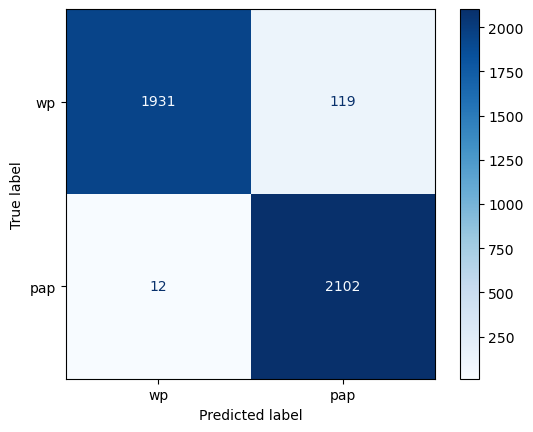

In [104]:
# look at matrics
compute_score(model_LR_simplified_randsearch, X_train, y_train)

Observation:

- Good performance, albeit still slightly worse than full model, indicating that there is value in keeping the other aspects of the tweets

----

## Model and Data Export

In [105]:
# export best estimators of each model
dill.dump(model_NB_randsearch.best_estimator_, open('../models/model_NB.sav', 'wb'))
dill.dump(model_NB_simplified_randsearch.best_estimator_, open('../models/model_NB_simplified.sav', 'wb'))
dill.dump(model_RF_randsearch.best_estimator_, open('../models/model_RF.sav', 'wb'))
dill.dump(model_RF_simplified_randsearch.best_estimator_, open('../models/model_RF_simplified.sav', 'wb'))
dill.dump(model_LR_randsearch.best_estimator_, open('../models/model_LR.sav', 'wb'))
dill.dump(model_LR_simplified_randsearch.best_estimator_, open('../models/model_LR_simplified.sav', 'wb'))

In [106]:
# export train and test sets
X_train.to_csv('../datasets/X_train.csv', index=False)
y_train.to_csv('../datasets/y_train.csv', index=False)
X_test.to_csv('../datasets/X_test.csv', index=False)
y_test.to_csv('../datasets/y_test.csv', index=False)